In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors

In [18]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

True

Kolekcija podataka koja se nalazi u datoteci "News_Category_Dataset_v2.json" sadrži podatke o novinskim člancima koji su sakupljeni tokom perioda od 2012 do 2018 sa sajta www.huffpost.com. Podaci koji će biti korišćeni mogu se naći na sledećem linku: https://www.kaggle.com/rmisra/news-category-dataset.

In [3]:
data = pd.read_json("News_Category_Dataset_v2.json", lines = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
print("Broj autora : ", data["authors"].nunique())

Broj autora :  27993


In [6]:
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [7]:
categories = data.groupby('category')
print("UKUPAN BROJ RAZLIČITIH KATEGORIJA: ", categories.ngroups)
print(categories.size())

UKUPAN BROJ RAZLIČITIH KATEGORIJA:  41
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
THE WORLDPOST      3664
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS      

Neke kategorije sadrže isti tip vesti a kategorija nosi sličan naziv, pa čemo izvršiti spajanje:

In [8]:
data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
data.category = data.category.map(lambda x: "WORLD NEWS" if x == "WORLDPOST" else x)
data.category = data.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE" else x)
data.category = data.category.map(lambda x: "STYLE AND BEAUTY" if x == "STYLE & BEAUTY" else x)
data.category = data.category.map(lambda x: "PARENT" if x == "PARENTING" else x)
data.category = data.category.map(lambda x: "ARTS & CULTURE" if x == "ARTS" else x)
data.category = data.category.map(lambda x: "ARTS & CULTURE" if x == "CULTURE & ARTS" else x)

In [9]:
categories_after_grouping = data.groupby('category')
print("UKUPAN BROJ RAZLIČITIH KATEGORIJA NAKON SPAJANJA: ", categories_after_grouping.ngroups)
print(categories_after_grouping.size())

UKUPAN BROJ RAZLIČITIH KATEGORIJA NAKON SPAJANJA:  37
category
ARTS & CULTURE       3878
BLACK VOICES         4528
BUSINESS             5937
COLLEGE              1144
COMEDY               5175
CRIME                3405
DIVORCE              3426
EDUCATION            1004
ENTERTAINMENT       16058
ENVIRONMENT          1323
FIFTY                1401
FOOD & DRINK         6226
GOOD NEWS            1398
GREEN                2622
HEALTHY LIVING       6694
HOME & LIVING        4195
IMPACT               3459
LATINO VOICES        1129
MEDIA                2815
MONEY                1707
PARENT               8677
PARENTS              3955
POLITICS            32739
QUEER VOICES         6314
RELIGION             2556
SCIENCE              2178
SPORTS               4884
STYLE & BEAUTY       9649
STYLE AND BEAUTY     2254
TASTE                2096
TECH                 2082
TRAVEL               9887
WEDDINGS             3651
WEIRD NEWS           2670
WELLNESS            17827
WOMEN                3490
W

Izvršićemo brisanje onih članaka kod kojih je naslov kratak:

In [10]:
print("Broj clanaka: ", data.shape[0])
data = data[data['headline'].apply(lambda x: len(x.split())>6)]
print("Broj clanaka nakon brisanja: ", data.shape[0])

Broj clanaka:  200853
Broj clanaka nakon brisanja:  167360


Izvšićemo brisanje članaka koji su duplirani:

In [11]:
print("Broj clanaka pre brisanja: ", data.shape[0])
data.sort_values('headline', inplace=True, ascending=False)
duplicates = data.duplicated('headline', keep = False)
data = data[~duplicates]
print("Broj clanaka nakon brisanja: ", data.shape[0])

Broj clanaka pre brisanja:  167360
Broj clanaka nakon brisanja:  165699


<ipython-input-11-b85d4cef84b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('headline', inplace=True, ascending=False)


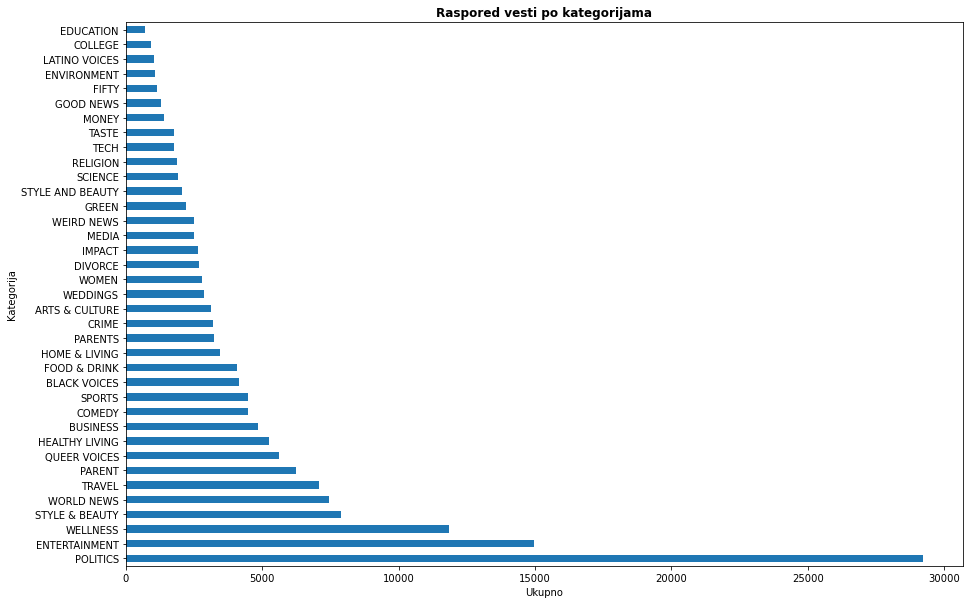

In [12]:
data['category'].value_counts().plot(kind='barh', figsize=(15,10))
plt.xlabel("Ukupno")
plt.ylabel("Kategorija")
plt.title("Raspored vesti po kategorijama", fontweight="bold", size=12);
plt.show()

Izmenićemo podatke kako bi nam odgovarali za klasifikaciju i nova tabela će sadržati kolone 'kategorija' i 'tekst' koja će biti spojena od kolona 'headline', 'short_description' i 'authors':

In [13]:
data['tekst'] = data['headline'] + data['short_description'] + data['authors']
data['kategorija'] = data['category']

del data['headline']
del data['short_description']
del data['date']
del data['authors']
del data['link']
del data['category']

data.head(10)

,tekst,kategorija
36290,"“We Shall Overcomb!” Say The 100,000 Marching ...",WOMEN
21194,“To The Bone” Didn’t Teach Me Glamour. It Taug...,HEALTHY LIVING
29672,"“I’m Sorry""--The Two Tragically Forgotten Word...",BUSINESS
199048,‘Your Divorce Ruined My Life' What To Do When ...,DIVORCE
193783,"‘You Better Sit Down,' By The Civilians, At Fl...",DIVORCE
112446,‘Yes' Is Better Than ‘No' When It Comes To Con...,WOMEN
2932,‘Will & Grace’ Creator To Donate Gay Bunny Boo...,QUEER VOICES
67601,‘Wild Boar Curling’ Rescues Stranded Wild Boar...,WEIRD NEWS
85380,‘We’re Never Gonna Forget’: Eric Garner’s Fami...,BLACK VOICES
25186,‘We Are the Same Blood’: The Invisible Lives O...,WORLD NEWS


Izvršićemo uklanjanje stop reči iz engleskog jezika(znakovi interpunkcije, česte reči kao što su a, an, the, I i slično):

In [14]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [15]:
STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)

lemmatizer = WordNetLemmatizer()

def preprocessing_text(text):
    text = text.lower()
    text = re.compile('[/(){}\[\]\|@,;]').sub('', text) 
    text = re.compile('[^0-9a-z #+_]').sub('', text)
    
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in STOPWORDS:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    text = " ".join(clean_text)
    
    return text

In [16]:
data['tekst'] = data['tekst'].apply(preprocessing_text)

Sačuvaćemo izmenjene podatke u novu datoteku radi lakšeg korišćenja kasnije:

In [1]:
data.to_csv('vesti.csv', columns=['tekst', 'kategorija'])


NameError: name 'data' is not defined